# Integrating single-cell transcriptomes from multiple samples

## Install the required libraries

In [1]:
download.file("https://github.com/eddelbuettel/r2u/raw/master/inst/scripts/add_cranapt_jammy.sh",
              "add_cranapt_jammy.sh")
Sys.chmod("add_cranapt_jammy.sh", "0755")
system("./add_cranapt_jammy.sh")
bspm::enable()
options(bspm.version.check=FALSE)

Tracing function "install.packages" in package "utils"



We will create an R function to performs system calls

In [2]:
shell_call <- function(command, ...) {
  result <- system(command, intern = TRUE, ...)
  cat(paste0(result, collapse = "\n"))
}

Install required libraries

In [3]:
install.packages("R.utils")

remotes::install_github('satijalab/seurat-wrappers@d28512f804d5fe05e6d68900ca9221020d52cf1d', upgrade=F)
remotes::install_github('satijalab/seurat-data')
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager", quiet = T)
install.packages("harmony")


Installing 77 packages: Rcpp, sitmo, BH, RcppProgress, dqrng, RcppAnnoy, irlba, FNN, polyclip, deldir, spatstat.utils, spatstat.data, tensor, abind, goftest, spatstat.sparse, spatstat.random, spatstat.geom, promises, later, sourcetools, xtable, httpuv, plyr, parallelly, listenv, globals, RcppArmadillo, matrixStats, gridExtra, reshape2, future, future.apply, RcppEigen, bitops, caTools, gtools, gplots, png, here, RcppTOML, crosstalk, lazyeval, htmlwidgets, shiny, zoo, igraph, reticulate, dotCall64, spam, progressr, sp, uwot, spatstat.explore, sctransform, scattermore, Rtsne, RSpectra, ROCR, RcppHNSW, RANN, plotly, pbapply, patchwork, miniUI, lmtest, leiden, ica, ggridges, ggrepel, fitdistrplus, fastDummies, cowplot, SeuratObject, Seurat, rsvd, BiocManager



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpRGuxON/remotes9f6aef56a0/satijalab-seurat-wrappers-d28512f/DESCRIPTION’ ... OK
* preparing ‘SeuratWrappers’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘SeuratWrappers_0.3.1.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




digest (0.6.34 -> 0.6.35) [CRAN]


Installing 1 packages: digest



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpRGuxON/remotes9f33aae66b/satijalab-seurat-data-4dc08e0/DESCRIPTION’ ... OK
* preparing ‘SeuratData’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘SeuratData_0.2.2.9001.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## Introduction

In this example of integrating multiple datasets representing, for example, different biological conditions, sample handling, or experimental protocols, we will explore the integration performed by [Seurat](https://www.cell.com/cell/fulltext/S0092-8674(19)30559-8) and [Harmony](https://www.nature.com/articles/s41592-019-0619-0) separately.

In [4]:
library(Seurat)
library(SeuratData)
library(SeuratWrappers)
library(cowplot)
library(harmony)
options(timeout=2000)

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.3.0 but the current version is
4.3.3; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Loading required package: Rcpp



## Loading Data

Here we load our datasets of interest to perform the integration.

This tutorial walks through an alignment of two groups of PBMCs from [Kang et al, 2017](https://www.nature.com/articles/nbt.4042). In this experiment, PBMCs were split into a stimulated and control group and the stimulated group was treated with interferon beta. The response to interferon caused cell type specific gene expression changes that makes a joint analysis of all the data difficult, with cells clustering both by stimulation condition and by cell type.

In [5]:
# install dataset
InstallData("ifnb")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [6]:
# load dataset
LoadData("ifnb")

Validating object structure

Updating object slots

Ensuring keys are in the proper structure

Warning message:
“Assay RNA changing from Assay to Assay”
Ensuring keys are in the proper structure

Ensuring feature names don't have underscores or pipes

Updating slots in RNA

Validating object structure for Assay ‘RNA’

Object representation is consistent with the most current Seurat version

Warning message:
“Assay RNA changing from Assay to Assay5”


An object of class Seurat 
14053 features across 13999 samples within 1 assay 
Active assay: RNA (14053 features, 0 variable features)
 2 layers present: counts, data

In [7]:
sc_datasets <- ifnb

In [8]:
sc_datasets %>% dplyr::glimpse()

Formal class 'Seurat' [package "Seurat"] with 13 slots


Warning message:
“Not a validObject(): no slot of name "images" for this object of class "Seurat"”


  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay' [package "Seurat"] with 8 slots


Warning message:
“Not a validObject(): no slot of name "assay.orig" for this object of class "Assay"”


  ..@ meta.data   :'data.frame':	13999 obs. of  5 variables:
  .. ..$ orig.ident        : chr [1:13999] "IMMUNE_CTRL" "IMMUNE_CTRL" "IMMUNE_CTRL" "IMMUNE_CTRL" ...
  .. ..$ nCount_RNA        : num [1:13999] 3017 2481 3420 3156 1868 ...
  .. ..$ nFeature_RNA      : int [1:13999] 877 713 850 1109 634 557 980 581 880 669 ...
  .. ..$ stim              : chr [1:13999] "CTRL" "CTRL" "CTRL" "CTRL" ...
  .. ..$ seurat_annotations: Factor w/ 13 levels "CD14 Mono","CD4 Naive T",..: 1 1 1 12 3 1 7 2 6 1 ...
  ..@ active.assay: chr "RNA"
  ..@ active.ident: Factor w/ 2 levels "IMMUNE_CTRL",..: 1 1 1 1 1 1 1 1 1 1 ...
  .. ..- attr(*, "names")= chr [1:13999] "AAACATACATTTCC.1" "AAACATACCAGAAA.1" "AAACATACCTCGCT.1" "AAACATACCTGGTA.1" ...
  ..@ graphs      : list()
  ..@ neighbors   : list()
  ..@ reductions  : list()
  ..@ project.name: chr "ifnb"
  ..@ misc        : list()
  ..@ version     :Classes 'package_version', 'numeric_version'  hidden list of 1
  .. ..$ : int [1:3] 3 0 0
  ..@ commands   

## Data Preprocessing

We preprocess the data to a point that is in common for both Seurat and Harmony data integration,

In [12]:
sc_datasets <- UpdateSeuratObject(object = sc_datasets) # If we dont run this throw a error 'no slot of name "images" for this object of class "Seurat"', maybe a issue of version of seurat object
sc_datasets <- Seurat::NormalizeData(sc_datasets, verbose = FALSE)

Validating object structure

Updating object slots

Ensuring keys are in the proper structure

Ensuring keys are in the proper structure

Ensuring feature names don't have underscores or pipes

Updating slots in RNA

Setting assay used for NormalizeData.RNA to RNA

Validating object structure for Assay ‘RNA’

Object representation is consistent with the most current Seurat version



Here, NormalizeData performs a normalization wherein feature counts for each cell are divided by the total counts for that cell and multiplied by the scale.factor. This is then natural-log transformed using log1p.

In [13]:
dplyr::glimpse(sc_datasets)

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay' [package "SeuratObject"] with 8 slots
  ..@ meta.data   :'data.frame':	13999 obs. of  5 variables:
  .. ..$ orig.ident        : chr [1:13999] "IMMUNE_CTRL" "IMMUNE_CTRL" "IMMUNE_CTRL" "IMMUNE_CTRL" ...
  .. ..$ nCount_RNA        : num [1:13999] 3017 2481 3420 3156 1868 ...
  .. ..$ nFeature_RNA      : int [1:13999] 877 713 850 1109 634 557 980 581 880 669 ...
  .. ..$ stim              : chr [1:13999] "CTRL" "CTRL" "CTRL" "CTRL" ...
  .. ..$ seurat_annotations: Factor w/ 13 levels "CD14 Mono","CD4 Naive T",..: 1 1 1 12 3 1 7 2 6 1 ...
  ..@ active.assay: chr "RNA"
  ..@ active.ident: Factor w/ 2 levels "IMMUNE_CTRL",..: 1 1 1 1 1 1 1 1 1 1 ...
  .. ..- attr(*, "names")= chr [1:13999] "AAACATACATTTCC.1" "AAACATACCAGAAA.1" "AAACATACCTCGCT.1" "AAACATACCTGGTA.1" ...
  ..@ graphs      : list()
  ..@ neighbors   : list()
  ..@ reductions  : list()
  ..@ images      : li

## Run Seurat data integration

The integration performed here with Seurat consists of using a Canonical Correlation Analysis to identify anchors between datasets, as indicated in the [original paper](https://www.cell.com/cell/fulltext/S0092-8674(19)30559-8):

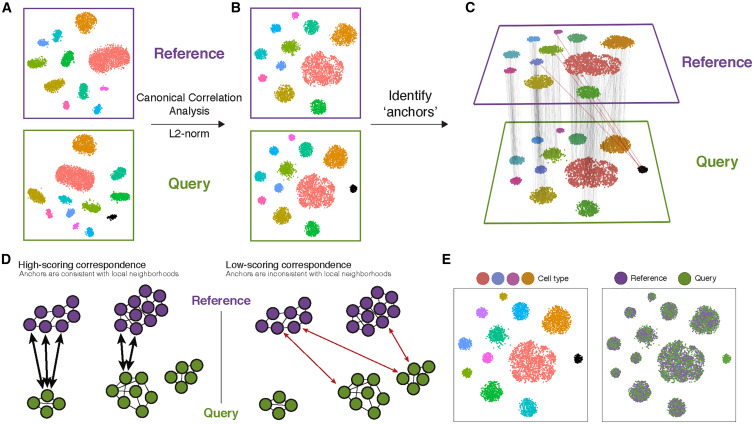

Split dataset into a list of datasets

In [14]:
sc_datasets.list <- SplitObject(sc_datasets,split.by = "stim")

Find highly variable features for each condition separately

In [15]:
sc_datasets.list <- lapply(X = sc_datasets.list, FUN = function(x) {
                    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
                    })

Find the features that are repeatedly variable across datasets for integration (anchor features).

In [16]:
features <- SelectIntegrationFeatures(object.list = sc_datasets.list)

Find the integration anchors or final set of highly variable genes most frequently selected across the batches

In [17]:
sc_datasets.anchors <- FindIntegrationAnchors(object.list = sc_datasets.list, anchor.features = features)

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 16393 anchors

Filtering anchors

	Retained 6756 anchors



Integrate datasets - Creates an integrated data assay

In [18]:
sc_datasets.combined <- IntegrateData(anchorset = sc_datasets.anchors)

Merging dataset 1 into 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data



In [19]:
dplyr::glimpse(sc_datasets.combined)

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 2
  .. ..$ RNA       :Formal class 'Assay' [package "SeuratObject"] with 8 slots
  .. ..$ integrated:Formal class 'Assay' [package "SeuratObject"] with 8 slots
  ..@ meta.data   :'data.frame':	13999 obs. of  5 variables:
  .. ..$ orig.ident        : chr [1:13999] "IMMUNE_CTRL" "IMMUNE_CTRL" "IMMUNE_CTRL" "IMMUNE_CTRL" ...
  .. ..$ nCount_RNA        : num [1:13999] 3017 2481 3420 3156 1868 ...
  .. ..$ nFeature_RNA      : int [1:13999] 877 713 850 1109 634 557 980 581 880 669 ...
  .. ..$ stim              : chr [1:13999] "CTRL" "CTRL" "CTRL" "CTRL" ...
  .. ..$ seurat_annotations: chr [1:13999] "CD14 Mono" "CD14 Mono" "CD14 Mono" "pDC" ...
  ..@ active.assay: chr "integrated"
  ..@ active.ident: Factor w/ 2 levels "IMMUNE_CTRL",..: 1 1 1 1 1 1 1 1 1 1 ...
  .. ..- attr(*, "names")= chr [1:13999] "AAACATACATTTCC.1" "AAACATACCAGAAA.1" "AAACATACCTCGCT.1" "AAACATACCTGGTA.1" ...
  ..@ graphs      : list(

Run the standard workflow for visualization and clustering.

In [20]:
sc_datasets.combined <- ScaleData(sc_datasets.combined, verbose = FALSE) %>%
                        RunPCA(npcs = 30, verbose = FALSE) %>%
                        RunUMAP(reduction = "pca", dims = 1:30) %>%
                        FindNeighbors(reduction = "pca", dims = 1:30) %>%
                        FindClusters(resolution = 0.5)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
14:57:55 UMAP embedding parameters a = 0.9922 b = 1.112

14:57:55 Read 13999 rows and found 30 numeric columns

14:57:55 Using Annoy for neighbor search, n_neighbors = 30

14:57:55 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:57:58 Writing NN index file to temp file /tmp/RtmpRGuxON/file9f4f177d31

14:57:58 Searching Annoy index using 1 thread, search_k = 3000

14:58:05 Annoy recall = 100%

14:58:05 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 13999
Number of edges: 568996

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9056
Number of communities: 15
Elapsed time: 3 seconds


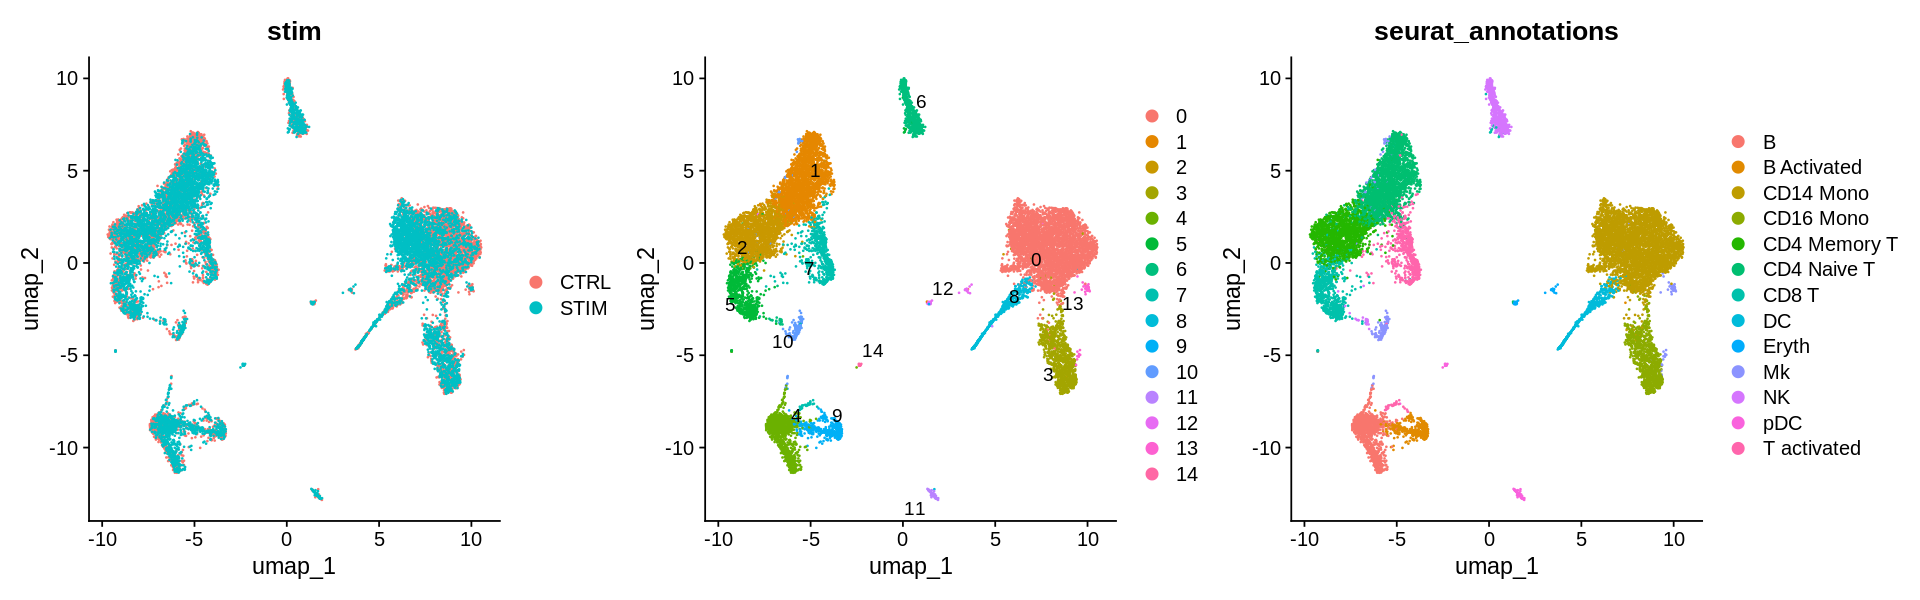

In [21]:
options(repr.plot.height = 5, repr.plot.width = 16)
# Visualization
p1 <- DimPlot(sc_datasets.combined, reduction = "umap", group.by = "stim")
p2 <- DimPlot(sc_datasets.combined, reduction = "umap", label = TRUE, repel = TRUE)
p3 <- DimPlot(sc_datasets.combined, reduction = "umap", group.by = "seurat_annotations")
p1 + p2 + p3

## Run Harmony

From the [original paper](https://www.nature.com/articles/s41592-019-0619-0) of harmony: "PCA embeds cells into a space with reduced dimensionality. Harmony accepts the cell coordinates in this reduced space and runs an iterative algorithm to adjust for dataset specific effects. **a**, Harmony uses fuzzy clustering to assign each cell to multiple clusters, while a penalty term ensures that the diversity of datasets within each cluster is maximized. **b**, Harmony calculates a global centroid for each cluster, as well as dataset-specific centroids for each cluster. **c**, Within each cluster, Harmony calculates a correction factor for each dataset based on the centroids. **d**, Finally, Harmony corrects each cell with a cell-specific factor: a linear combination of dataset correction factors weighted by the cell’s soft cluster assignments made in step a. Harmony repeats steps a to d until convergence. The dependence between cluster assignment and dataset diminishes with each round. Datasets are represented with colors, cell types with different shapes."

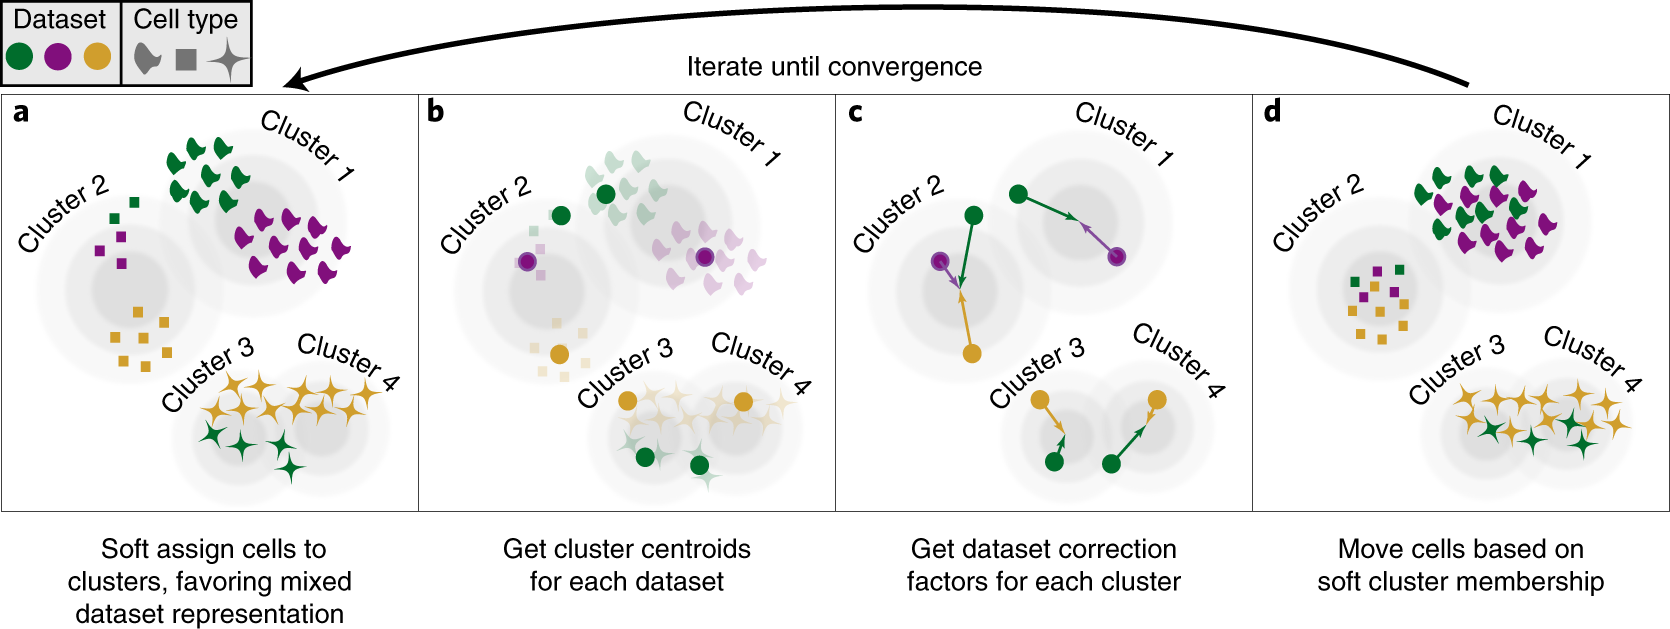



Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony converged after 5 iterations



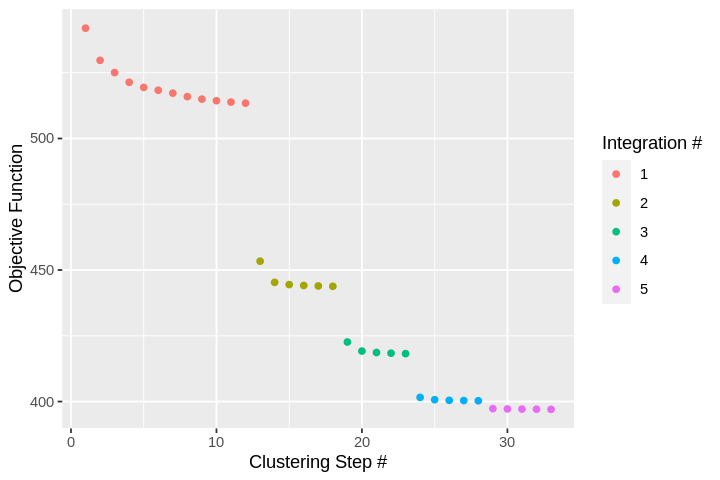

In [22]:
options(repr.plot.height = 4, repr.plot.width = 6)
sc_datasets.harmony <- FindVariableFeatures(sc_datasets, selection.method = "vst", nfeatures = 2000) %>%
                       ScaleData(verbose = FALSE) %>%
                       RunPCA(npcs = 30, verbose = FALSE) %>%
                       RunHarmony("stim", plot_convergence = TRUE)

To directly access the harmonized embeddings:


In [23]:
harmony_embeddings <- Embeddings(sc_datasets.harmony, 'harmony')
harmony_embeddings[1:5, 1:5]

,harmony_1,harmony_2,harmony_3,harmony_4,harmony_5
AAACATACATTTCC.1,-11.5176221,0.9849327,1.8257515,-0.05207354,0.3094558
AAACATACCAGAAA.1,-12.0136557,2.5915149,-2.7852694,-0.42822463,-1.6136651
AAACATACCTCGCT.1,-9.6494634,2.6353962,-0.3379965,-0.85520964,0.4967801
AAACATACCTGGTA.1,0.8962454,-1.9783608,13.3802569,5.94855123,-1.2597261
AAACATACGATGAA.1,7.1235846,0.1068811,-1.4046818,-2.59205277,-0.1800091


Complete the standard workflow for visualization and clustering

In [24]:
sc_datasets.harmony <- RunUMAP(sc_datasets.harmony, reduction = "harmony", dims = 1:30) %>%
                       FindNeighbors(reduction = "harmony", dims = 1:30) %>%
                       FindClusters(resolution = 0.5)

14:58:52 UMAP embedding parameters a = 0.9922 b = 1.112

14:58:52 Read 13999 rows and found 30 numeric columns

14:58:52 Using Annoy for neighbor search, n_neighbors = 30

14:58:52 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:58:54 Writing NN index file to temp file /tmp/RtmpRGuxON/file9f4aa48fe5

14:58:54 Searching Annoy index using 1 thread, search_k = 3000

14:59:02 Annoy recall = 100%

14:59:02 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

14:59:03 Initializing from normalized Laplacian + noise (using RSpectra)

14:59:04 Commencing optimization for 200 epochs, with 619034 positive edges

14:59:13 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 13999
Number of edges: 519284

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8984
Number of communities: 14
Elapsed time: 5 seconds


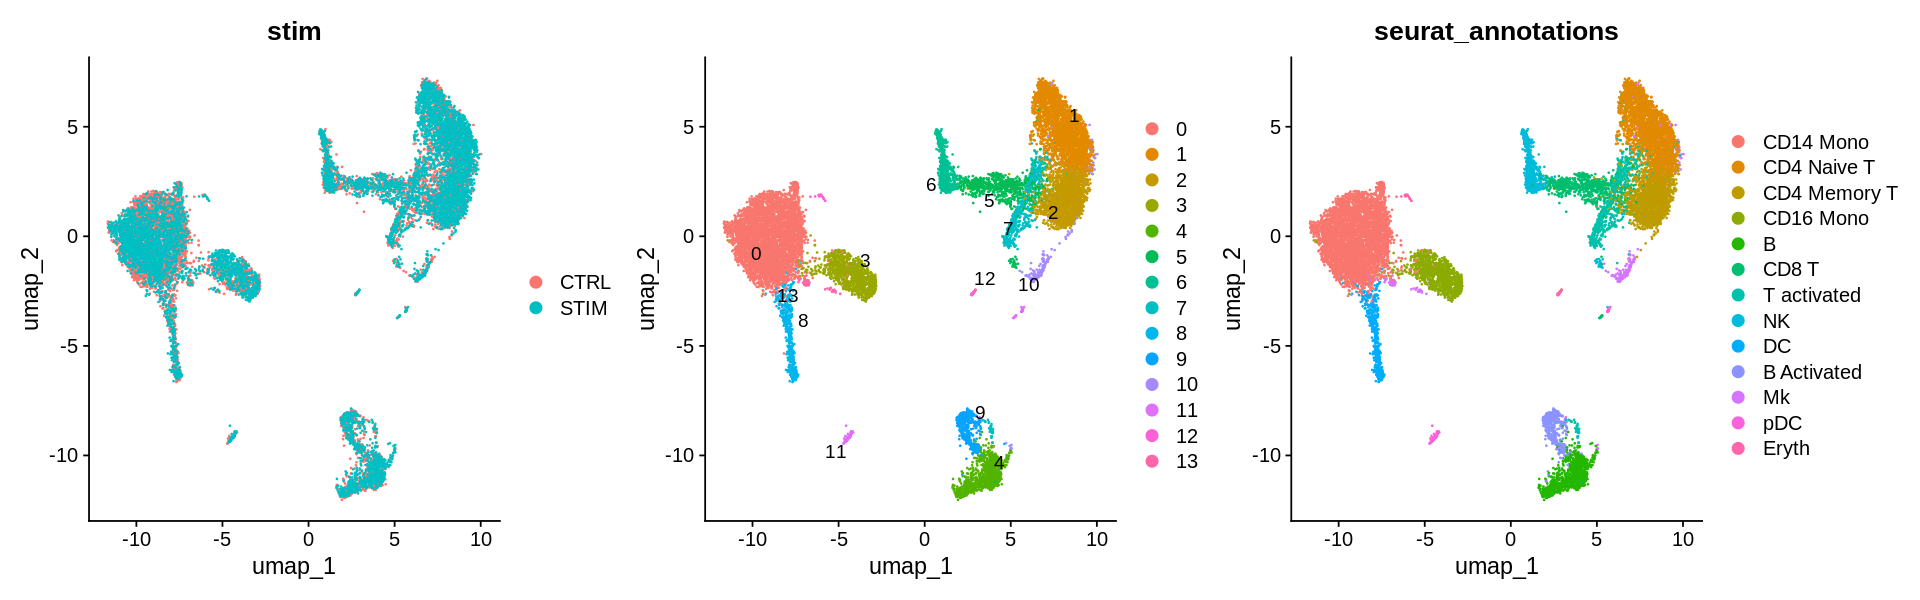

In [25]:
options(repr.plot.height = 5, repr.plot.width = 16)
# Visualization
p1 <- DimPlot(sc_datasets.harmony, reduction = "umap", group.by = "stim")
p2 <- DimPlot(sc_datasets.harmony, reduction = "umap", label = TRUE, repel = TRUE)
p3 <- DimPlot(sc_datasets.harmony, reduction = "umap", group.by = "seurat_annotations")
p1 + p2 + p3

## Integration Metrics

Inspect mixing within cluster

We will use a function to plot the batch composition of each cluster.

This function was borrowed from: https://github.com/cellgeni/scRNA.seq.course/blob/master/course_files/utils/custom_seurat_functions.R

In [26]:
plot_integrated_clusters = function (srat, batchcolumn) {
  ## take an integrated Seurat object, plot distributions over orig.ident
  library(Seurat)
  library(patchwork)
  library(ggplot2)
  library(reshape2)
  library(RColorBrewer)


  count_table <- table(srat@meta.data$seurat_clusters, srat@meta.data[[batchcolumn]])
  count_mtx   <- as.data.frame.matrix(count_table)
  count_mtx$cluster <- rownames(count_mtx)
  melt_mtx    <- melt(count_mtx)
  melt_mtx$cluster <- as.factor(melt_mtx$cluster)

  cluster_size   <- aggregate(value ~ cluster, data = melt_mtx, FUN = sum)

  sorted_labels <- paste(sort(as.integer(levels(cluster_size$cluster)),decreasing = T))
  cluster_size$cluster <- factor(cluster_size$cluster,levels = sorted_labels)
  melt_mtx$cluster <- factor(melt_mtx$cluster,levels = sorted_labels)

  colnames(melt_mtx)[2] <- "dataset"


  p1 <- ggplot(cluster_size, aes(y= cluster,x = value)) + geom_bar(position="dodge", stat="identity",fill = "grey60") +
    theme_bw() + scale_x_log10() + xlab("Cells per cluster, log10 scale") + ylab("")
  p2 <- ggplot(melt_mtx,aes(x=cluster,y=value,fill=dataset)) +
    geom_bar(position="fill", stat="identity") + theme_bw() + coord_flip() +
    scale_fill_brewer(palette = "Set2") +
    ylab("Fraction of cells in each dataset") + xlab("Cluster number") + theme(legend.position="top")

  p2 + p1 + plot_layout(widths = c(3,1))
  }


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots


Using cluster as id variables



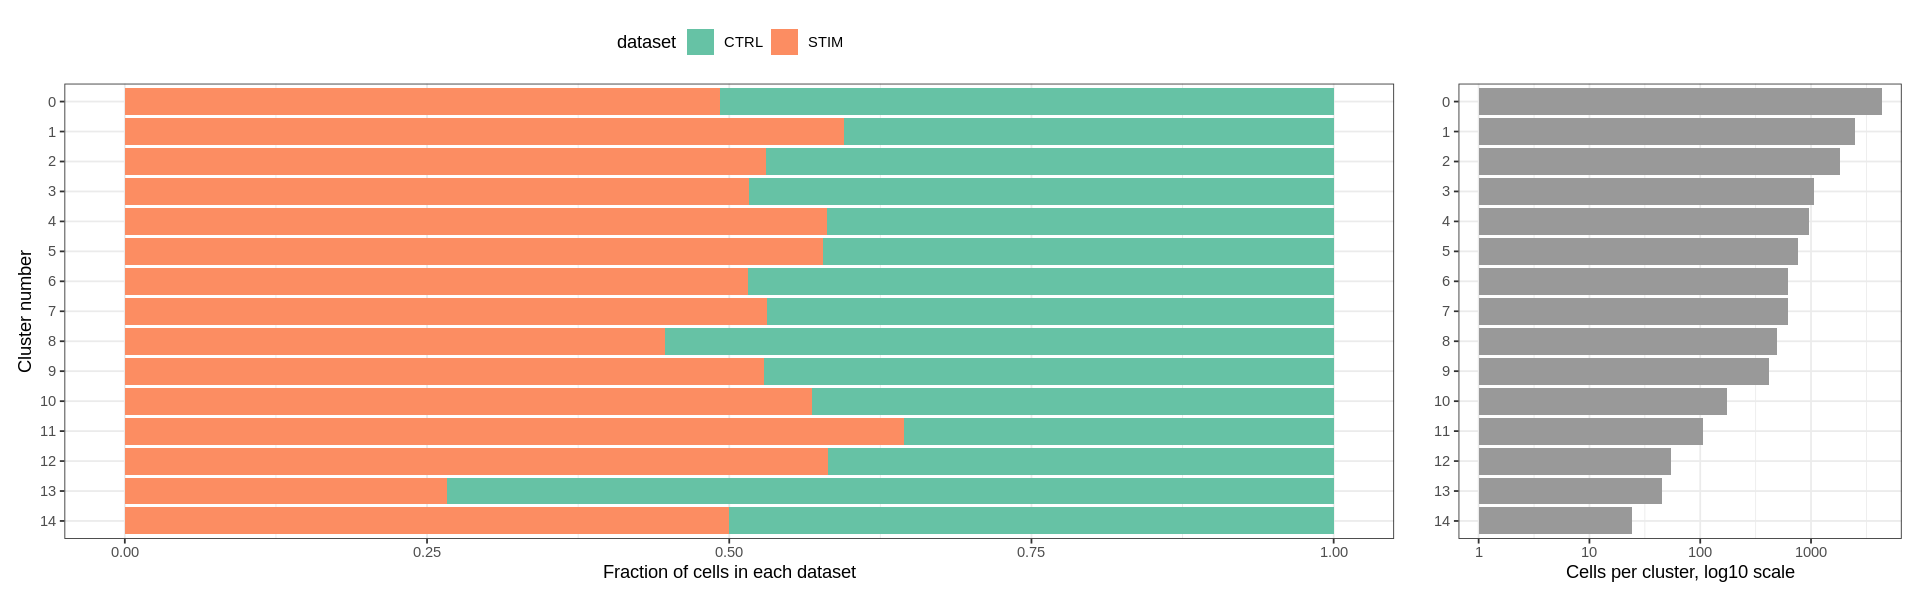

In [27]:
plot_integrated_clusters(sc_datasets.combined, 'stim')

Using cluster as id variables



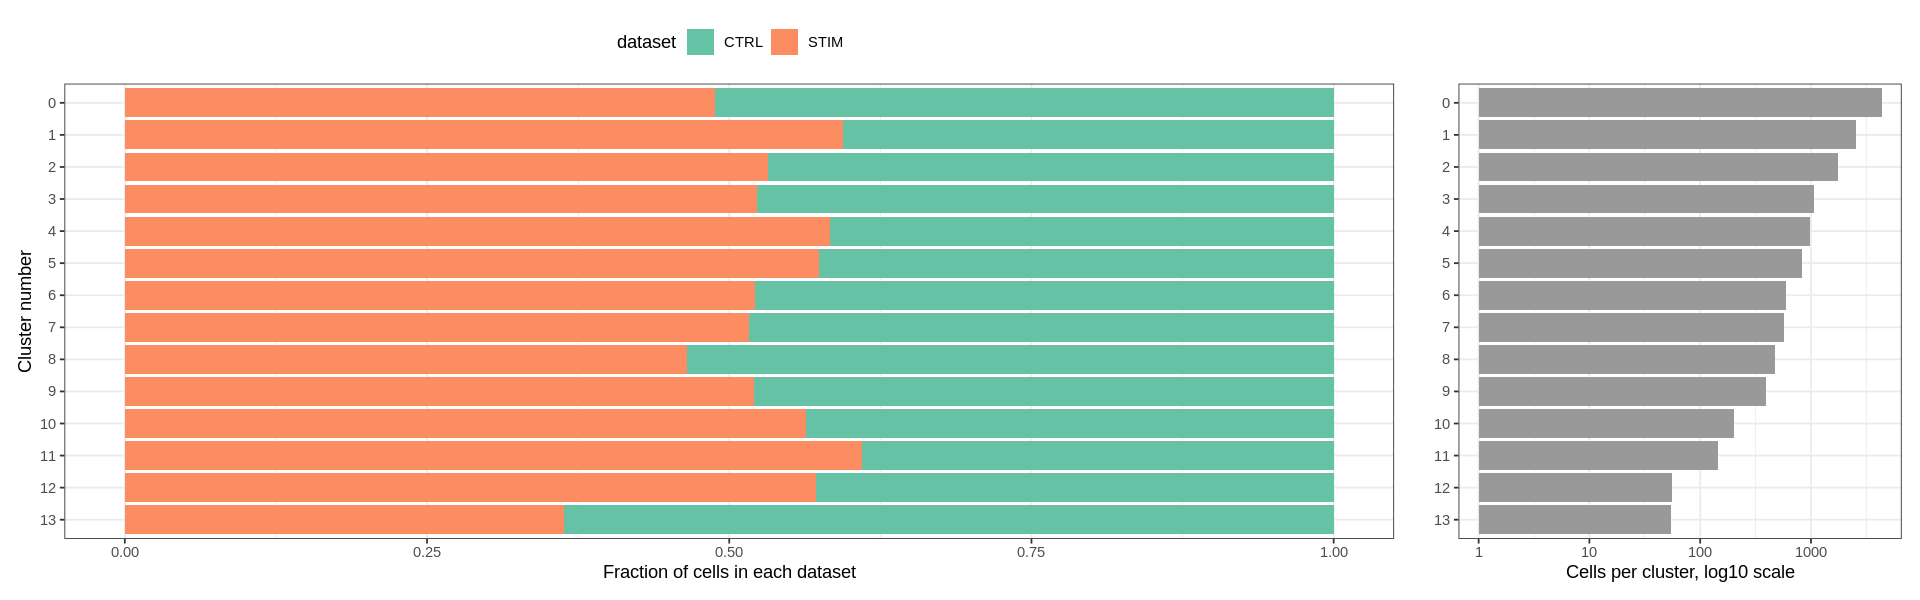

In [28]:
plot_integrated_clusters(sc_datasets.harmony, 'stim')

This measures how well mixed a composite dataset is. According to [this link](https://github.com/satijalab/Integration2019/issues/1#issuecomment-573757488), lower scores represent better mixing. See also [this code](https://github.com/satijalab/Integration2019/blob/e5821bd242fa0a46eb6fd37764275737512032a4/analysis_code/integration/integration_metrics.R#L43C1-L45C124)

This metric evaluates whether the neighborhood of a cell is well mixed. In other words, whether it contains a small number of cells from each dataset (e.g., k=5).

In [29]:
seurat_mixing <- MixingMetric(sc_datasets.combined,
                              'seurat_clusters', # 'cca.aligned'
                              reduction = "pca",
                              dims = 1:2,
                              k = 5,
                              max.k = 300,
                              eps = 0,
                              verbose = TRUE
                             )

In [30]:
mean(seurat_mixing)

[1] 299.7066

In [31]:
sd(seurat_mixing)

[1] 5.752467

In [32]:
harmony_mixing <- MixingMetric(sc_datasets.harmony,
                               'seurat_clusters',
                               reduction = "harmony",
                               dims = 1:2,
                               k = 5,
                               max.k = 300,
                               eps = 0,
                               verbose = TRUE
                             )

In [33]:
mean(harmony_mixing)

[1] 282.6719

In [34]:
sd(harmony_mixing)

[1] 39.19456

# Let's compare when using no integration, Seurat, and Harmony:

In [35]:
sc_datasets <-  FindVariableFeatures(sc_datasets, selection.method = "vst", nfeatures = 2000) %>%
                ScaleData(verbose = FALSE) %>%
                RunPCA(npcs = 30, verbose = FALSE) %>%
                RunUMAP(reduction = "pca", dims = 1:30) %>%
                FindNeighbors(reduction = "pca", dims = 1:30) %>%
                FindClusters(resolution = 0.5)

15:00:42 UMAP embedding parameters a = 0.9922 b = 1.112

15:00:42 Read 13999 rows and found 30 numeric columns

15:00:42 Using Annoy for neighbor search, n_neighbors = 30

15:00:42 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:00:45 Writing NN index file to temp file /tmp/RtmpRGuxON/file9f1d6d8665

15:00:45 Searching Annoy index using 1 thread, search_k = 3000

15:00:51 Annoy recall = 100%

15:00:52 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

15:00:53 Initializing from normalized Laplacian + noise (using RSpectra)

15:00:54 Commencing optimization for 200 epochs, with 614362 positive edges

15:01:02 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 13999
Number of edges: 557766

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9256
Number of communities: 16
Elapsed time: 3 seconds


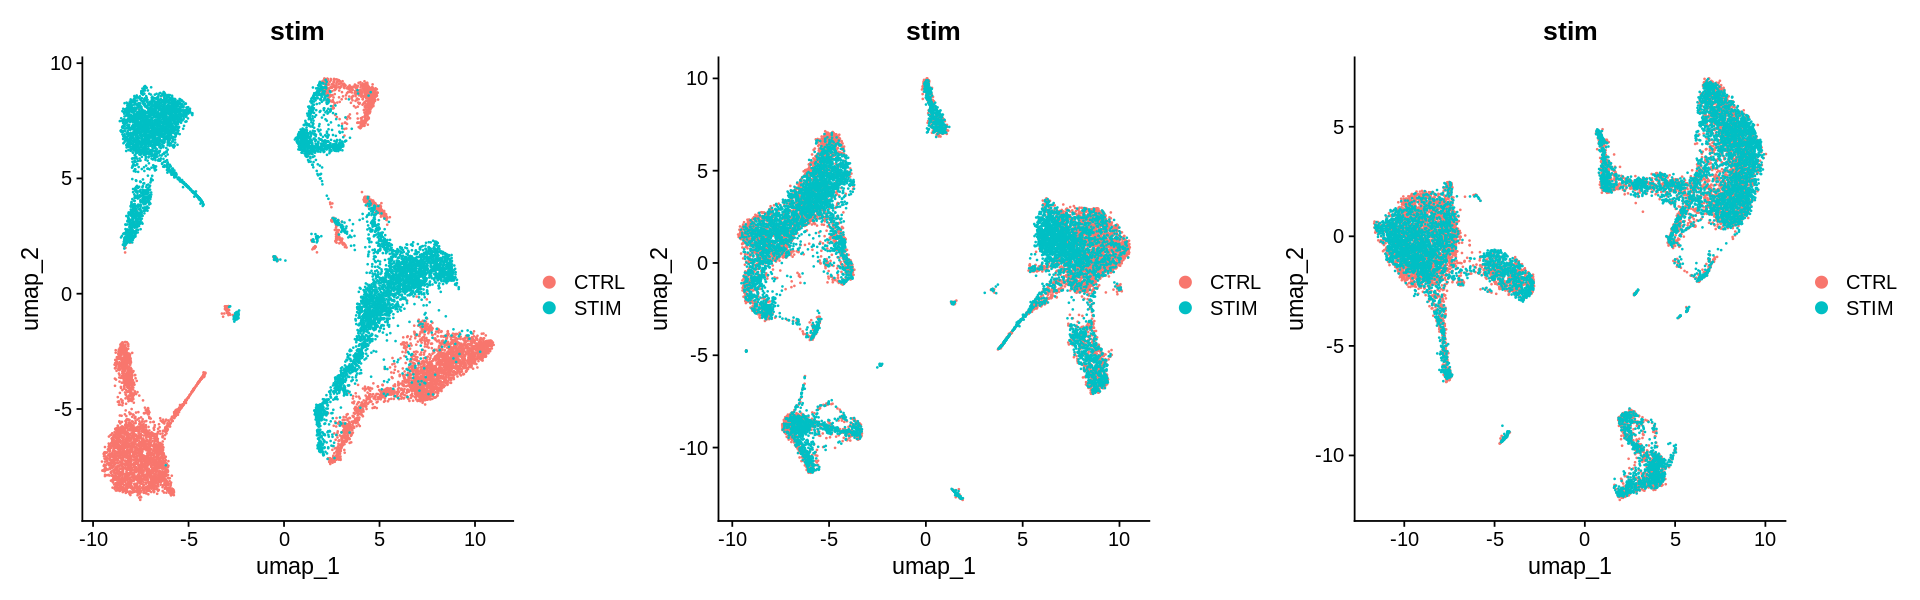

In [36]:
options(repr.plot.height = 5, repr.plot.width = 16)
# Visualization
p1 <- DimPlot(sc_datasets, reduction = "umap", group.by = "stim")
p2 <- DimPlot(sc_datasets.combined, reduction = "umap", group.by = "stim")
p3 <- DimPlot(sc_datasets.harmony, reduction = "umap", group.by = "stim")

p1 + p2 + p3

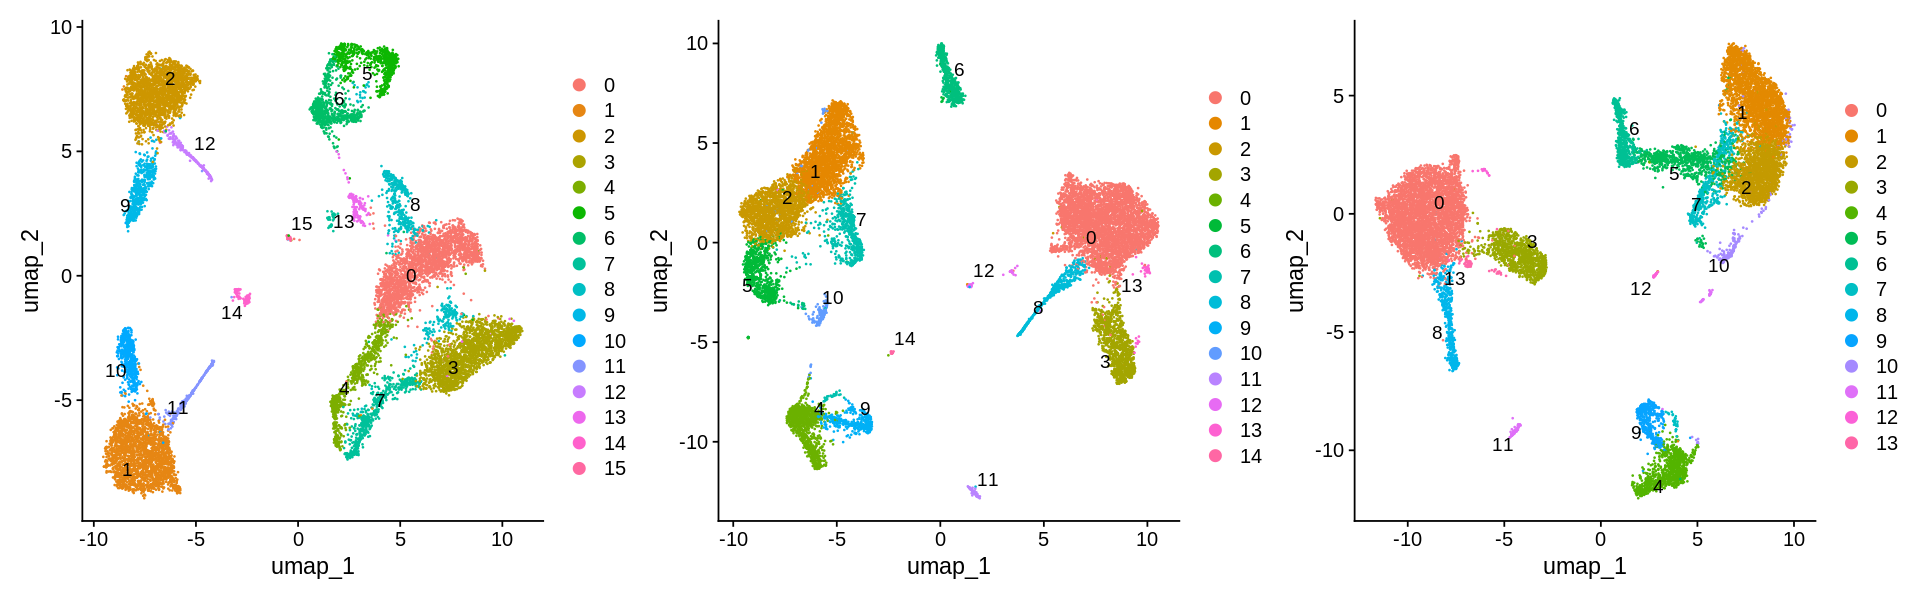

In [37]:
options(repr.plot.height = 5, repr.plot.width = 16)
# Visualization
p1 <- DimPlot(sc_datasets, reduction = "umap", label = TRUE, repel = TRUE)
p2 <- DimPlot(sc_datasets.combined, reduction = "umap", label = TRUE, repel = TRUE)
p3 <- DimPlot(sc_datasets.harmony, reduction = "umap", label = TRUE, repel = TRUE)

p1 + p2 + p3

## Extra Questions:

- How different are the results between the Seurat and Harmony integration?

- Why can this happen?

- Can you identify which markers changed in the clusters generated in one method vs the other?

In [38]:
?DimPlot